<a href="https://colab.research.google.com/github/rocoomak/Twitter-sentiment-and-emotion-analysis/blob/main/Twitter_sentimentA2Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Requirements**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 12
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Getting Data**

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Twitter_dataset_million.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 470 ms, sys: 0 ns, total: 470 ms
Wall time: 471 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

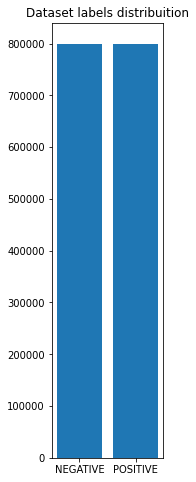

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(2,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

#**Perprocessing and Cleaning Data**

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 52.8 s, sys: 254 ms, total: 53.1 s
Wall time: 53.1 s


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 2.75 s, sys: 360 ms, total: 3.11 s
Wall time: 3.11 s


## **Word2Vector**

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2021-08-09 10:24:00,196 : INFO : collecting all words and their counts
2021-08-09 10:24:00,198 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-08-09 10:24:00,235 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2021-08-09 10:24:00,254 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2021-08-09 10:24:00,277 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2021-08-09 10:24:00,301 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2021-08-09 10:24:00,322 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2021-08-09 10:24:00,344 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2021-08-09 10:24:00,374 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2021-08-09 10:24:00,396 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-08-09 10:24:36,361 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-08-09 10:24:37,419 : INFO : EPOCH 1 - PROGRESS: at 5.32% examples, 417504 words/s, in_qsize 15, out_qsize 0
2021-08-09 10:24:38,453 : INFO : EPOCH 1 - PROGRESS: at 10.75% examples, 424222 words/s, in_qsize 13, out_qsize 2
2021-08-09 10:24:39,458 : INFO : EPOCH 1 - PROGRESS: at 16.27% examples, 433242 words/s, in_qsize 14, out_qsize 4
2021-08-09 10:24:40,471 : INFO : EPOCH 1 - PROGRESS: at 22.22% examples, 445663 words/s, in_qsize 15, out_qsize 0
2021-08-09 10:24:41,511 : INFO : EPOCH 1 - PROGRESS: at 27.86% examples, 445609 words/s, in_qsize 15, out_qsize 0
2021-08-09 10:24:42,571 : INFO : EPOCH 1 - PROGRESS: at 33.81% examples, 448464 words/s, in_qsize 15, out_qsize 0
2021-08-09 10:24:43,596 : INFO : EPOCH 1 - PROGRESS: at 39.43% examples, 448939 words/s, in_qsize 15, out_qsize 0
2021-08-09 10:24:44,640 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 19min 11s, sys: 5.49 s, total: 19min 16s
Wall time: 9min 56s


(263124969, 295270528)

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec.load('/content/drive/My Drive/model.w2v')

2021-08-09 10:34:38,626 : INFO : loading Word2Vec object from /content/drive/My Drive/model.w2v
2021-08-09 10:34:43,594 : INFO : loading wv recursively from /content/drive/My Drive/model.w2v.wv.* with mmap=None
2021-08-09 10:34:43,596 : INFO : setting ignored attribute vectors_norm to None
2021-08-09 10:34:43,601 : INFO : loading vocabulary recursively from /content/drive/My Drive/model.w2v.vocabulary.* with mmap=None
2021-08-09 10:34:43,602 : INFO : loading trainables recursively from /content/drive/My Drive/model.w2v.trainables.* with mmap=None
2021-08-09 10:34:43,604 : INFO : setting ignored attribute cum_table to None
2021-08-09 10:34:43,606 : INFO : loaded /content/drive/My Drive/model.w2v


In [ ]:
w2v_model.most_similar("twitter")

[('facebook', 0.5836625099182129),
 ('twiiter', 0.5476189255714417),
 ('linkedin', 0.525221049785614),
 ('tweetdeck', 0.523249089717865),
 ('tweets', 0.5224666595458984),
 ('tweet', 0.52085280418396),
 ('friendfeed', 0.5107216835021973),
 ('twitted', 0.5070906281471252),
 ('replies', 0.5020990967750549),
 ('tweeter', 0.49893391132354736)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 16.3 s, sys: 88.2 ms, total: 16.4 s
Wall time: 16.4 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 24.5 s, sys: 729 ms, total: 25.2 s
Wall time: 25 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
x_train[:5]

array([[    0,     0,     0, ...,   712,   118, 24590],
       [    0,     0,     0, ...,   452,   378, 32447],
       [    0,     0,     0, ...,  2048,     4,  5487],
       [    0,     0,     0, ...,     5,     8,     7],
       [    0,     0,     0, ...,    63,  1643,  1338]], dtype=int32)

In [ ]:
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# **Support Vector Machine**

In [ ]:
%%time
modal = SVC(kernel='linear')
modal.fit(x_train, y_train)
y_pred_test = modal.predict(x_test)
print("Accuracy Of SVM :",accuracy_score(y_test, y_pred_test))
print("Confusion Mtrix:\n",confusion_matrix(y_test, y_pred_test))


# **K Means Clustering**

In [ ]:
%%time
from sklearn.cluster import KMeans
modal = KMeans(n_clusters= 2)
modal.fit(x_train, y_train)
y_pred_test = modal.predict(x_test)
print("Accuracy of K Means Clustering",accuracy_score(y_test, y_pred_test))
print("Confusion Matix\n",confusion_matrix(y_test, y_pred_test))

# **Random Forest Classifier**

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
modal = RandomForestClassifier(n_estimators = 2)
modal.fit(x_train, y_train)
y_pred_test = modal.predict(x_test)
print("Accuracy of Random Forest Classifier",accuracy_score(y_test, y_pred_test))
print("Confusion Matrix\n",confusion_matrix(y_test, y_pred_test))

Accuracy of Random Forest Classifier 0.56426875
Confusion Matrix
 [[124104  35390]
 [104044  56462]]
CPU times: user 16.5 s, sys: 317 ms, total: 16.8 s
Wall time: 16.9 s


# **Long Short Term Memory**

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-08-09 10:55:30,050 : WARNING : Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/model.h5')

2021-08-09 11:42:55,928 : WARNING : Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 55s 170ms/step - loss: 0.4467 - accuracy: 0.7891

ACCURACY: 0.789118766784668
LOSS: 0.4466644525527954
CPU times: user 51.6 s, sys: 1.65 s, total: 53.3 s
Wall time: 54.9 s


In [ ]:
 print(history.history['accuracy'])

NameError: ignored

Accuracy and Loss Graph

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Epoch_16.png')
plt.show()


NameError: ignored

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
predict("I love cricket")

{'elapsed_time': 0.9035966396331787,
 'label': 'POSITIVE',
 'score': 0.8638536334037781}

In [ ]:
predict("best")

{'elapsed_time': 0.11944198608398438,
 'label': 'POSITIVE',
 'score': 0.9017211198806763}

In [ ]:
predict("this is ball")

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()


In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

# **Saving Trained Model**

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)